## Import Packages

1. To build a recurrent neural network, we start by importing the Dense layer, Activation layer, and Loss function that you implemented in Lab4 & Flatten layer you implemented in Lab5. Ensure the following three files are located in the same directory as this notebook, and follow the instructions to complete the setup:
    - Dense.py : Copy the **Dense class** you had implemented in Lab4 to it.
    - Activation.py : Copy the **Activation class** you had implemented in Lab4 to it.
    - Loss.py : Copy **compute_CCE_loss** function you had implemented in Lab4 to it.
    - Flatten.py: Copy **Flatten class** you had implemented in Lab5 to it.\
    Note: you should copy both `forward()` and `backward()` in class `Flatten` in Lab5.


⚠️ **WARNING** ⚠️:
*   Please do not import any other packages in this lab.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ###
...
### END CODE HERE ###
```



### Mount Google Drive (optional)

In [1]:
### START CODE HERE ###
# from google.colab import drive
import os
# drive.mount('/content/drive')
# os.chdir('YOUR PATH')
### END CODE HERE ###

In [2]:
###### import your Lab4 & Lab5 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_CCE_loss, compute_MSE_loss
from Flatten import Flatten
##################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

outputs = {}

# Basic Part

## RNN Class (30%)
The RNN class implements a simple Recurrent Neural Network (RNN) layer. This class includes methods for initializing parameters, performing the forward pass, computing gradients during the backward pass, and updating the weights.

Structure overview:
<figure> <img src="https://imgur.com/nU7xrBe.png" width="580" height="400">
</figure>
RNN connection:
<figure>
<img src="https://imgur.com/4JQX0se.png" width="500" height="250">
</figure>
Data insights:
<figure> <img src="https://imgur.com/c2MI3mj.png" width="400" height="220">
</figure>
In each neuron:
<figure> <img src="https://imgur.com/luXS4zv.png" width="300" height="220">
</figure>

1.   **Initializaon**

    *   `input_size`: The number of input features for each time step.
    *   `rnn_units`: The number of units (neurons) in the RNN layer.
    *   `seed`: A random seed for weight initialization to ensure reproducibility.

2.   **Initialize parameters** (3%)
    * `Wx`: The weight matrix for the input to hidden connections. It has a shape of `(rnn_units, input_size)`
    * `Wh`: The weight matrix for the hidden to hidden connections. It has a shape of `(rnn_units, rnn_units)`
    * `bh`: The bias vector for the hidden state. It has a shape of `(rnn_units, 1)`, where rnn_units is the number of units in the RNN layer.
3.  **Forward** (12%) \
* `X`: Input data of shape `(batch_size, timesteps, input_size)`
* The forward pass computes the hidden state `h_t` (shape of `(batch_size, self.rnn_units)`)at each time step `t` using the following formula:
$ h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$
    * $W_x$ is the weight matrix for the input to hidden connections.
    * $W_h$ is the weight matrix for the hidden to hidden connections.
    * $b_h$ is the bias vector.
    * $x_t$ is the input at time step t.
    * $h_{t-1}$ is the hidden state from the previous time step.
    * $\tanh$ is the hyperbolic tangent activation function.
* Output would be shape of `(batch_size, rnn_units)`
4. **Backward** (15%) \
Reference (Backpropagation Through Time):
https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html
* `dH`: Gradient of the loss with respect to the hidden state, typically of shape `(batch_size, rnn_units, 1)`.
* The backward pass computes the gradients of the loss with respect to the weights and biases using the following formulas:
    * Gradient of the loss with respect to the hidden state(derivative of `tanh`):\
    $\delta_t = (1 - h_t^2) \cdot \delta_{t+1}$
        * $\delta_t$ is the gradient of the loss with respect to the hidden state at time step t.
        * $h_t$ is the hidden state at time step t
    * Gradients with respect to the weights and biases (accumulate the gradients over all time steps):
        1. $\frac{\partial L}{\partial W_x} = ∑_{t=0}^{timesteps} \delta_t^T \cdot x_t$
        2. $\frac{\partial L}{\partial W_h} = ∑_ {t=0}^{timesteps} \delta_t^T \cdot h_{t-1}$
        3. $\frac{\partial L}{\partial b_h} = ∑_{t=0}^{timesteps} \delta_t^T$
        * $\frac{\partial L}{\partial W_x}$ is the gradient of the loss with respect to the input to hidden weights.
        * $\frac{\partial L}{\partial W_h}$ is the gradient of the loss with respect to the hidden to hidden weights.
        * $\frac{\partial L}{\partial b_h}$ is the gradient of the loss with respect to the hidden bias.
        * $x_t$ is the input at time step t.
        * $h_{t-1}$ is the hidden state from the previous time step.
    * Gradient with respect to the previous hidden state:
    $\frac{\partial L}{\partial h_{t-1}} = \delta_t \cdot W_h$
    * Then divide each gradient by `batch_size`.
    * Gradient clipping (optional) is recommended in RNN since RNN rely on backpropagation through time where data might contain large timesteps and it might cause gradient explosion or vanishing. **Note**: You can't do gradient clipping in the function testing (`test_baward()`)


In [3]:
class RNN():
    def __init__(self, input_size, rnn_units, seed=1):
        """
        Initialize the SimpleRNN layer.

        Parameters:
        input_size (int): Number of input features.
        rnn_units (int): Number of units in the RNN layer.
        seed (int): Random seed for weight initialization.
        """
        self.input_size = input_size
        self.rnn_units = rnn_units
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize the weights and biases for the RNN layer.
        """
        np.random.seed(self.seed)

        ### START CODE HERE ###
        # Multiply by 0.01 is for testing reason.
        self.Wx = np.random.randn(self.rnn_units, self.input_size) * 0.01 # Input to hidden weights , with shape of (rnn_units, input_size).
        self.Wh = np.random.randn(self.rnn_units, self.rnn_units) * 0.01  # Hidden to hidden weights, with shape of (rnn_units, rnn_units).
        self.bh = np.zeros((self.rnn_units, 1))                           # Hidden bias, with shape of (rnn_units, 1).
        ### END CODE HERE ###

    def forward(self, X):
        """
        Perform the forward pass through the RNN layer.

        Parameters:
        X (ndarray): Input data of shape (batch_size, timesteps, input_size).

        Returns:
        ndarray: Output of the RNN layer (hidden state).
        """
        batch_size, timesteps, _ = X.shape
        ### START CODE HERE ###
        self.h = np.zeros((batch_size, self.rnn_units)) # Initialize hidden state, with shape of (batch_size, self.rnn_units).
        self.hs = []                                    # Store hidden states for backward pass, list of self.h.
        ### END CODE HERE ###

        self.xs = []  # Store inputs for backward pass

        for t in range(timesteps):
            ### START CODE HERE ###
            x_t = X[:, t, :] # Get input at time step t for all data in X.
            self.xs.append(x_t)
            self.h = np.tanh(x_t @ self.Wx.T + self.h @ self.Wh.T + self.bh.T) # Update hidden state according to the formula of h_t.
            self.hs.append(self.h)
            ### END CODE HERE ###

        return self.h


    def backward(self, dH):
        """
        Perform the backward pass through the RNN layer.

        Parameters:
        dH (ndarray): Gradient of the loss with respect to the hidden state.
        clip_value (float): Value to clip the gradients to prevent exploding gradients.

        Returns:
        ndarray: Gradient of the loss with respect to the input.
        """
        batch_size, _ = dH.shape
        ### START CODE HERE ###
        self.dL_dWx = np.zeros_like(self.Wx) # Initialized with same shape as Wx.
        self.dL_dWh = np.zeros_like(self.Wh) # Initialized with same shape as Wh.
        self.dL_dbh = np.zeros_like(self.bh) # Initialized with same shape as bh.
        ### END CODE HERE ###
        dL_dh = dH

        for t in reversed(range(len(self.hs))):
            x_t = self.xs[t]  # Get input at time step t
            h = self.hs[t]
            h_prev = self.hs[t-1] if t > 0 else np.zeros_like(h)
            ### START CODE HERE ###
            dL_dh_raw = (1 - h**2) * dL_dh                                     # Derivative of tanh
            self.dL_dWx = self.dL_dWx + (dL_dh_raw.T @ x_t)                    # Gradient w.r.t. Wx
            self.dL_dWh = self.dL_dWh + dL_dh_raw.T @ h_prev                   # Gradient w.r.t. Wh
            self.dL_dbh = self.dL_dbh + dL_dh_raw.T @ np.ones((batch_size, 1)) # Gradient w.r.t. bh
            dL_dh = dL_dh_raw @ self.Wh                                        # Gradient w.r.t. previous hidden state (Wh)
            ### END CODE HERE ###

        ### START CODE HERE ###
        # Average gradients over the batch.
        self.dL_dWx = self.dL_dWx / batch_size
        self.dL_dWh = self.dL_dWh / batch_size
        self.dL_dbh = self.dL_dbh / batch_size
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Gradient part (optional), you can't run this part while testing the backward function !!!
        # clip_value = 2.0
        # Clip gradients to prevent exploding gradients
        # np.clip(self.dL_dWx, -clip_value, clip_value, out=self.dL_dWx)
        # np.clip(self.dL_dWh, -clip_value, clip_value, out=self.dL_dWh)
        # np.clip(self.dL_dbh, -clip_value, clip_value, out=self.dL_dbh)
        ### END CODE HERE ###

        return dL_dh

    def update(self, learning_rate):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        learning_rate (float): Learning rate for weight updates.
        """
        ### START CODE HERE ###
        # Update each weights.
        self.Wx = self.Wx - learning_rate * self.dL_dWx
        self.Wh = self.Wh - learning_rate * self.dL_dWh
        self.bh = self.bh - learning_rate * self.dL_dbh
        ### END CODE HERE ###

### Functions testing


#### `initialize_parameter` function

In [4]:
def test_initialization(save_to_output = False):
    input_size = 5
    rnn_units = 3
    rnn = RNN(input_size, rnn_units)
    print("Wx shape:", rnn.Wx.shape)
    print("Wh shape:", rnn.Wh.shape)
    print("bh shape:", rnn.bh.shape)
    if save_to_output == True:
        outputs['RNN_initialization'] = {"Wx shape": rnn.Wx.shape, "Wh shape": rnn.Wh.shape, "bh shape": rnn.bh.shape}
test_initialization(True)

Wx shape: (3, 5)
Wh shape: (3, 3)
bh shape: (3, 1)


Expected output:

|Output|Value|
|---|---|
|Wx shape:|(3, 5)|
|Wh shape:|(3, 3)|
|bh shape:|(3, 1)|

#### `forward` function


In [5]:
def test_forward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4
    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    # Create a sample input of shape (batch_size, timesteps, input_size)
    np.random.seed(seed)   # Don't change the seed!
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    output = rnn.forward(X)

    if save_to_output == False:
        # Print the output
        print("Input shape:", X.shape)
        print("Input:")
        print(X)
        print("Output shape of RNN layer:", output.shape)
        print("Output of the RNN layer (hidden state):")
        print(output)

    if save_to_output == True:
        outputs['RNN_forward'] = {"X shape": X.shape, "X": X, "Output shape": output.shape, "Output": output}

# Run the test with seed 1 to compare with expected outputs.
test_forward(1)

# Run with seed 42 and save the answer.
test_forward(42, True)

Input shape: (2, 4, 5)
Input:
[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
  [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
  [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]
  [-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]

 [[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]
  [-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]
  [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]
  [-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]
Output shape of RNN layer: (2, 3)
Output of the RNN layer (hidden state):
[[-0.00873835  0.02641052 -0.00287992]
 [-0.00596289 -0.01742189  0.02418844]]


Expected output of `forward`:

| Output | Value |
|---|---|
| Input shape | (2, 4, 5) |
| Input | `[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]`<br>  `[-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]`<br>  `[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]`<br>  `[-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]`<br><br> `[[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]`<br>  `[-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]`<br>  `[-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]`<br>  `[-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]]` |
| Output shape of RNN layer | (2, 3) |
| Output of the RNN layer (hidden state) | `[[-0.00873835  0.02641052 -0.00287992]`<br> `[-0.00596289 -0.01742189  0.02418844]]` |

#### `backward` function

In [6]:
def test_backward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4

    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    np.random.seed(seed)   # Don't change the seed!
    # Create a sample input of shape (batch_size, timesteps, input_size)
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    rnn.forward(X)
    # Create a sample gradient of the loss with respect to the hidden state
    dH = np.random.randn(batch_size, rnn_units)
    # Perform the backward pass
    dL_dX = rnn.backward(dH)
    if save_to_output == False:
        print("dH shape: ", dH.shape)
        print("dH:")
        print(dH)
        # Print the gradients
        print("dL_dX shape:", dL_dX.shape)
        print("Gradient w.r.t. input (dL_dX):")
        print(dL_dX)
        print("dL_dWx shape:", rnn.dL_dWx.shape)
        print("Gradient w.r.t. Wx (dL_dWx):")
        print(rnn.dL_dWx)
        print("dL_dWh shape:", rnn.dL_dWh.shape)
        print("Gradient w.r.t. Wh (dL_dWh):")
        print(rnn.dL_dWh)
        print("dL_dbh shape:", rnn.dL_dbh.shape)
        print("Gradient w.r.t. bh (dL_dbh):")
        print(rnn.dL_dbh)

    if save_to_output == True:
        outputs['RNN_backward'] = {"dH shape": dH.shape, "dH": dH, "dL_dX shape": dL_dX.shape, "dL_dX": dL_dX, "dL_dWx shape": rnn.dL_dWx.shape,
                                   "dL_dWx": rnn.dL_dWx, "dL_dWh shape": rnn.dL_dWh.shape, "dL_dWh": rnn.dL_dWh, "dL_dbh shape": rnn.dL_dbh.shape, "dL_dbh": rnn.dL_dbh}

# Run the test with seed 1 to compare with expected outputs.
test_backward(1)

# Run with seed 42 and save the answer.
test_backward(42, True)

dH shape:  (2, 3)
dH:
[[-0.19183555 -0.88762896 -0.74715829]
 [ 1.6924546   0.05080775 -0.63699565]]
dL_dX shape: (2, 3)
Gradient w.r.t. input (dL_dX):
[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]
 [ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]
dL_dWx shape: (3, 5)
Gradient w.r.t. Wx (dL_dWx):
[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]
 [ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]
 [ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]
dL_dWh shape: (3, 3)
Gradient w.r.t. Wh (dL_dWh):
[[-0.00663169  0.01738478 -0.0106337 ]
 [-0.02325593  0.03069429 -0.03469078]
 [-0.01936184  0.02200992 -0.02853306]]
dL_dbh shape: (3, 1)
Gradient w.r.t. bh (dL_dbh):
[[ 0.73406116]
 [-0.42812618]
 [-0.69714697]]


Expected output:

| Output | Value |
|---|---|
|dH shape:|(2, 3)|
|dH:|`[[-0.19183555 -0.88762896 -0.74715829]`<br>`[ 1.6924546   0.05080775 -0.63699565]]`|
|dL_dX shape:| (2, 3)|
|Gradient w.r.t. input (dL_dX):| `[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]`<br>`[ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]`|
|dL_dWx shape:| (3, 5)|
|Gradient w.r.t. Wx (dL_dWx):|`[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]`<br>`[ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]`<br>`[ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]`|
|dL_dWh shape:| (3, 3)|
|Gradient w.r.t. Wh (dL_dWh):|`[[-0.00663169  0.01738478 -0.0106337 ]`<br>`[-0.02325593  0.03069429 -0.03469078]`<br>`[-0.01936184  0.02200992 -0.02853306]]`|
|dL_dbh shape:| (3, 1)|
|Gradient w.r.t. bh (dL_dbh):|`[[ 0.73406116]`<br>`[-0.42812618]`<br>`[-0.69714697]]`|

## Model class (10%)
The `Model` class provides a framework for building and training neural networks.
1.   `add()` is just like the function in previous Lab, we can call `model.add( )` to sequentially add a layer into the model.
2.   `forward()` performs the forward propagation of data through the layers, calculating predictions
3.   In `backward()`, we have to check if the activation function is *softmax* to make sure we call the right `backward()`.
4.   `train()` function will be used to train the model, here, we can decide which loss function `BCE` or `MSE` we want to train with. And also calculate the loss for validation data.
5. `plot_losses()` function can show the history of the training and validation loss to see if the training works.

In [7]:
class Model():
    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Sequentially add a layer into the model.

        Parameters:
        layer: Different layers class.
        """
        ### START CODE HERE ###
        self.layers.append(layer)
        ### END CODE HERE ###

    def forward(self, X):
        for layer in self.layers:
            if layer.__class__.__name__ == 'RNN':
                if len(X.shape) < 3:                                # If the RNN layer is stacked after another RNN layer.
                    ### START CODE HERE ###
                    X = np.expand_dims(X, axis=1)                # We have to treat the output size of first layer (rnn_units) as the feature size (input_size) of the second layer.
                    ### END CODE HERE ###
                X = layer.forward(X)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dA, Y):
        for layer in reversed(self.layers):
            if isinstance(layer, Activation) and layer.activation_function == "softmax":
                ### START CODE HERE ###
                dA = layer.backward(Y=Y)                   # softmax activation backward.
                ### END CODE HERE ###
            else:
                ### START CODE HERE ###
                dA = layer.backward(dA)
                ### END CODE HERE ###
        return dA

    def update(self, learning_rate):
        for layer in self.layers:       # Update for every layers.
            ### START CODE HERE ###
            if layer.__class__.__name__ in ['RNN', 'Dense']:
                layer.update(learning_rate)
            ### END CODE HERE ###

    def train(self, X_train, y_train, X_val, y_val, epochs=10, learning_rate=0.001, batch_size = 64, loss_function='mse', lr_decay_step=80, lr_decay=1):
        self.train_losses = []  # Initialize a list to store training losses
        self.val_losses = []  # Initialize a list to store validation losses
        for epoch in range(epochs):
            os.system('clear')
            total_loss = 0
            ### START CODE HERE ###
            num_batches = X_train.shape[0] // batch_size    # Calculate the number of batches
            ### END CODE HERE ###

            with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for batch_idx in range(num_batches):

                    ### START CODE HERE ###
                    # Get the batch data
                    X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
                    y_batch = y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # 1. Forward to get the prediction.
                    # 2. Calculate the loss according to your parameters ('cce' or 'mse').
                    # 3. Calculate dA.
                    # 4. backward with the calculated dA.
                    # 5. update the parameters.
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss
                    dA = y_pred - y_batch
                    self.backward(dA, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

                    # Update the progress bar and loss every 5 iterations
                    if (batch_idx + 1) % 5 == 0:
                        pbar.set_postfix(loss=total_loss / (batch_idx + 1))
                    pbar.update(1)  # Increment the progress bar by 1 unit

                # Handle the remaining examples that do not fit into a full batch
                if len(X_train) % batch_size != 0:

                    # Get the remaining data
                    ### START CODE HERE ###
                    X_batch = X_train[batch_idx * batch_size:]
                    y_batch = y_train[batch_idx * batch_size:]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # Same as above in batch
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss
                    dA = y_pred - y_batch
                    self.backward(dA, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

            ### START CODE HERE ###
            avg_train_loss = total_loss / num_batches       # Calculate the average loss over batches.
            if (epoch + 1) % lr_decay_step == 0: learning_rate *= lr_decay
            ### END CODE HERE ###

            self.train_losses.append(avg_train_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

            # Validation part
            ### START CODE HERE ###
            # 1. Get the prediction
            # 2. compute the loss ('mse', 'cce').
            y_pred = self.forward(X_val)

            if loss_function == 'cce':
                val_loss = compute_CCE_loss(y_pred, y_val)
            elif loss_function == 'mse':
                val_loss = compute_MSE_loss(y_pred, y_val)
            ### END CODE HERE ###

            self.val_losses.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}')

    def predict(self, X):
        return self.forward(X)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

### `Model` class testing

In [8]:
def test_model_class(seed, save_to_output = False):
    np.random.seed(seed)
    input = np.random.randn(3, 3, 1)
    Y = np.expand_dims(np.array([1,0,1]),-1)

    model = Model()
    model.add(RNN(1, 4))
    model.add(RNN(4, 4))
    model.add(Dense(4, 1))
    model.add(Activation("sigmoid", None))

    AL = model.forward(input)
    dA_prev = model.backward(AL, Y=Y)
    model.update(0.1)
    if save_to_output == False:
        print("AL: ", AL)
        print("dA_prev: ", dA_prev)
        print("Wx of RNN: ", model.layers[0].Wx)
        print("Wh of RNN: ", model.layers[0].Wh)
        print("bh of RNN: ", model.layers[0].bh)

    if save_to_output == True:
        outputs['Model_class'] = {"AL": AL, "dA_prev": dA_prev, "Wx of RNN": model.layers[0].Wx, "Wh of RNN": model.layers[0].Wh, "bh of RNN": model.layers[0].bh}

# Run the test with seed 1 to compare with expected outputs.
test_model_class(1)

# Run with seed 42 and save the answer.
test_model_class(42, True)

AL:  [[0.50002597]
 [0.50011082]
 [0.49998505]]
dA_prev:  [[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]
 [ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]
 [ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]
Wx of RNN:  [[ 0.01609996]
 [-0.00598851]
 [-0.00519148]
 [-0.01059058]]
Wh of RNN:  [[ 0.00865366 -0.02301519  0.01744827 -0.00761178]
 [ 0.00319076 -0.00249388  0.01462095 -0.02060167]
 [-0.00322391 -0.00384067  0.0113376  -0.0109991 ]
 [-0.00172383 -0.00877879  0.00042198  0.00582784]]
bh of RNN:  [[ 0.00017288]
 [-0.00015564]
 [-0.00010827]
 [-0.00016452]]


Expected output:

|Output|Value|
|---|---|
|AL:| `[[0.50002597]`<br>`[0.50011082]`<br>`[0.49998505]]`|
|dA_prev:|`[[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]`<br>`[ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]`<br>`[ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]`|
|Wx of RNN:| `[[ 0.01609996]`<br>`[-0.00598851]`<br>`[-0.00519148]`<br>`[-0.01059058]]`|
|Wh of RNN:|`[[ 0.00865366 -0.02301519  0.01744827 -0.00761178]`<br>`[ 0.00319076 -0.00249388  0.01462095 -0.02060167]`<br>`[-0.00322391 -0.00384067  0.0113376  -0.0109991 ]`<br>`[-0.00172383 -0.00877879  0.00042198  0.00582784]]`|
|bh of RNN:|  `[[ 0.00017288]`<br>`[-0.00015564]`<br>`[-0.00010827]`<br>`[-0.00016452]]`|

### Save the above output to `.npy`

In [9]:
assert list(outputs.keys()) == ['RNN_initialization', 'RNN_forward', 'RNN_backward', 'Model_class']
np.save('Lab6_outputs.npy', outputs)
# sanity check for saved outputs
submit = np.load("Lab6_outputs.npy", allow_pickle=True).item()
for key, value in submit.items():
    if isinstance(value, dict):  # Check if value is a dictionary
        print(f"{key}:")
        for inner_key, inner_value in value.items():
            print(f"  {inner_key}: {type(inner_value)}")  # Print type of inner values
    else:
        print(f"{key}: {type(value)}")  # Print type of other values

RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>


Expected output:


```
RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>
```



## Sinusoidal wave dataset (20%)
In this section, we will generate a dataset of sinusoidal waves with varying frequencies, amplitudes, and random phase shifts. The **last value** in each sequence will be used as the target prediction. This dataset will be used for training and validating a model.



*   You can decide how many `num_samples`, `num_timesteps`, `freq_range` and `amp_range` you want to generate your own training dataset. (**there is no provided training dataset!**)
* ⚠⚠ You need to download X_test.csv from Kaggle and put it into Sinewave directory. (Or you have to change the path when generating prediction)
* For **testing data** on Kaggle, we used `num_timesteps = 100`, `0.5 <= freq_range <= 5` & `0.5 <= amp_range <= 5` to generate, your training dataset can try to cover these range in testing data.
* You need submit the `y_test.csv` to Kaggle
    * `MAPE <= 17%` -> 10 points
    * `MAPE <= 14%` -> 20 points
* **Kaggle Link**: https://www.kaggle.com/t/512f44fe285d4c1bb90c39884f8a2a33

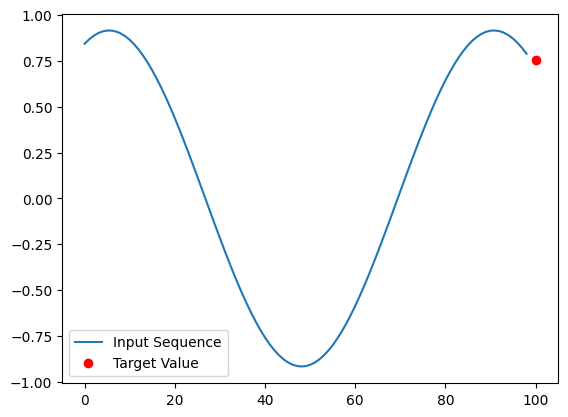

In [10]:
# Generate Sinusoidal Wave Dataset

def generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range):
    """
    Generate sine wave data with varying frequencies, amplitudes, and random phase shifts.
    The last value in each sequence is used as the target prediction.

    Parameters:
    - num_samples: Number of samples to generate.
    - num_timesteps: Number of timesteps for each sample.
    - freq_range: Tuple of floor and ceiling of frequency range.
    - amp_range: Tuple of floor and ceiling of amplitude range.

    Returns:
    - X: Generated sine wave data of shape (num_samples, num_timesteps - 1).
    - y: Target values of shape (num_samples,).
    """
    X = np.zeros((num_samples, num_timesteps - 1))
    y = np.zeros(num_samples)
    for i in range(num_samples):
        ### START CODE HERE ###
        # Choose the frequency, amplitude and shift phase value.
        freq = np.random.uniform(freq_range[0], freq_range[1]) # Random choose from freq_range.
        amp = np.random.uniform(amp_range[0], amp_range[1])    # Random choose from amp_range.
        phase_shift = np.random.uniform(0, 2 * np.pi)          # Random choose from (0, 2*pi).
        ### END CODE HERE ###

        t = np.linspace(0, 2 * np.pi, num_timesteps)
        sine_wave = amp * np.sin(freq * t + phase_shift)
        X[i] = sine_wave[:-1]  # All but the last value
        y[i] = sine_wave[-1]   # The last value
    return X, y

### START CODE HERE ###
# You can modify to your preferred range and number of samples. (Note: It's recommended to cover the range of testing data mentioned above.)
num_samples = 1600
num_timesteps = 100
freq_range = (0.5, 5.0)  # Frequency range
amp_range = (0.5, 5.0)   # Amplitude range
### END CODE HERE ###

X, y = generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range)

### START CODE HERE ###
# Split data into training and validation sets
X_train = X[:1200]
y_train = y[:1200]
X_val = X[1200:]
y_val = y[1200:]
### END CODE HERE ###

# Plot an example sequence
plt.plot(X_train[0], label='Input Sequence')
plt.plot(np.arange(num_timesteps, num_timesteps + 1), y_train[0], 'ro', label='Target Value')
plt.legend()
plt.show()


### Construct the model with Dense layer only
Here, we want you to construct the model with **Dense layer only** like you did in Lab4. You may modify the model structure and parameters in the way you like.

Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 1124.65batch/s, loss=11.1]


Epoch 1/20, Training Loss: 10.037293639465398
Epoch 1/20, Validation Loss: 6.656660216858543


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 2249.63batch/s, loss=6.52]


Epoch 2/20, Training Loss: 6.258681399550145
Epoch 2/20, Validation Loss: 4.8199645326524765


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 1499.99batch/s, loss=4.71]


Epoch 3/20, Training Loss: 4.674439401741286
Epoch 3/20, Validation Loss: 3.892478500075437


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 1285.85batch/s, loss=3.73]


Epoch 4/20, Training Loss: 3.783790572072388
Epoch 4/20, Validation Loss: 3.3080697373691352


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 1798.93batch/s, loss=3.1]


Epoch 5/20, Training Loss: 3.194219070993411
Epoch 5/20, Validation Loss: 2.8939751041763944


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 1500.23batch/s, loss=2.65]


Epoch 6/20, Training Loss: 2.766554758371957
Epoch 6/20, Validation Loss: 2.579145532062895


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 1500.35batch/s, loss=2.31]


Epoch 7/20, Training Loss: 2.439300797707374
Epoch 7/20, Validation Loss: 2.3271650246117823


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 1799.87batch/s, loss=2.04]


Epoch 8/20, Training Loss: 2.1789146920789175
Epoch 8/20, Validation Loss: 2.118567551634934


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 1500.35batch/s, loss=1.83]


Epoch 9/20, Training Loss: 1.9653428104662791
Epoch 9/20, Validation Loss: 1.9410493166709422


Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 1798.93batch/s, loss=1.65]


Epoch 10/20, Training Loss: 1.785972774491356
Epoch 10/20, Validation Loss: 1.7869585298009707


Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 1800.39batch/s, loss=1.5]


Epoch 11/20, Training Loss: 1.6329252083307433
Epoch 11/20, Validation Loss: 1.6518541347730178


Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 1800.47batch/s, loss=1.38]


Epoch 12/20, Training Loss: 1.5005696974339782
Epoch 12/20, Validation Loss: 1.5319924366142772


Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 642.83batch/s, loss=1.27]


Epoch 13/20, Training Loss: 1.384813589549629
Epoch 13/20, Validation Loss: 1.4251433135323848


Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 1000.05batch/s, loss=1.17]


Epoch 14/20, Training Loss: 1.2828493196853157
Epoch 14/20, Validation Loss: 1.3292777193140126


Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 1799.79batch/s, loss=1.09]


Epoch 15/20, Training Loss: 1.192266677644832
Epoch 15/20, Validation Loss: 1.242687988970931


Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 2250.16batch/s, loss=1.01]


Epoch 16/20, Training Loss: 1.1113658127280248
Epoch 16/20, Validation Loss: 1.1643013616786517


Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 2251.51batch/s, loss=0.946]


Epoch 17/20, Training Loss: 1.038834017370651
Epoch 17/20, Validation Loss: 1.0929504043302647


Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 1800.22batch/s, loss=0.887]


Epoch 18/20, Training Loss: 0.973501196568298
Epoch 18/20, Validation Loss: 1.0276237427031694


Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 1801.08batch/s, loss=0.833]


Epoch 19/20, Training Loss: 0.9144225740402963
Epoch 19/20, Validation Loss: 0.9678405053005582


Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 2250.16batch/s, loss=0.785]


Epoch 20/20, Training Loss: 0.8607742126443623
Epoch 20/20, Validation Loss: 0.9130864696447921


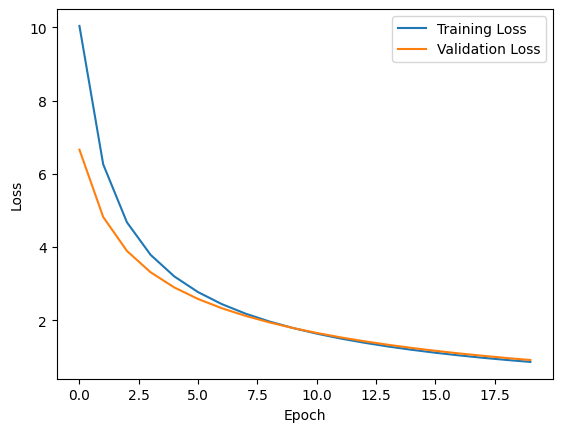

In [11]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Only contain Dense layer here!!!)
# Reshape the input data to fit Dense model
input_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
# Construct the model with Dense layers

model = Model()
model.add(Dense(input_size, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 1))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.001, batch_size = 128, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For Dense model)
For this prediction of Dense model, you can choose not to submit it to Kaggle if its performance is not better.

In [12]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
# download
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###

# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


### Construct the model with RNN layer
Then, we can integrate our custom-built RNN layer into the model to evaluate whether it improves performance on the sequential inputs.

Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 510.74batch/s, loss=1.11]


Epoch 1/20, Training Loss: 1.1074254283120588
Epoch 1/20, Validation Loss: 0.31871464119992304


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 451.80batch/s, loss=0.247]


Epoch 2/20, Training Loss: 0.246712551174053
Epoch 2/20, Validation Loss: 0.23128485967718873


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 510.16batch/s, loss=0.185]


Epoch 3/20, Training Loss: 0.18524929871213397
Epoch 3/20, Validation Loss: 0.18002785819541228


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 518.09batch/s, loss=0.145]


Epoch 4/20, Training Loss: 0.14502150661047472
Epoch 4/20, Validation Loss: 0.14225886991807143


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 519.98batch/s, loss=0.113]


Epoch 5/20, Training Loss: 0.11252658569352597
Epoch 5/20, Validation Loss: 0.10971878369559146


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 511.84batch/s, loss=0.0855]


Epoch 6/20, Training Loss: 0.08553434135984349
Epoch 6/20, Validation Loss: 0.08439259566140493


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 376.88batch/s, loss=0.0655]


Epoch 7/20, Training Loss: 0.06549794480382912
Epoch 7/20, Validation Loss: 0.06544971003561571


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 313.81batch/s, loss=0.0502]


Epoch 8/20, Training Loss: 0.05017332537224636
Epoch 8/20, Validation Loss: 0.05085464145692178


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 303.32batch/s, loss=0.0384]


Epoch 9/20, Training Loss: 0.03835866887628371
Epoch 9/20, Validation Loss: 0.039813466721182175


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 304.88batch/s, loss=0.0295]


Epoch 10/20, Training Loss: 0.029494077287904843
Epoch 10/20, Validation Loss: 0.031552146579521524


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 291.83batch/s, loss=0.0231]


Epoch 11/20, Training Loss: 0.02305507608142289
Epoch 11/20, Validation Loss: 0.02562772528911799


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 306.13batch/s, loss=0.0186]


Epoch 12/20, Training Loss: 0.018573680635557248
Epoch 12/20, Validation Loss: 0.02143691299717195


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 290.18batch/s, loss=0.0155]


Epoch 13/20, Training Loss: 0.015499678861432947
Epoch 13/20, Validation Loss: 0.018416259276700354


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 289.38batch/s, loss=0.0134]


Epoch 14/20, Training Loss: 0.013392167757688646
Epoch 14/20, Validation Loss: 0.01620869371770349


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 309.73batch/s, loss=0.0119]


Epoch 15/20, Training Loss: 0.011926873040158706
Epoch 15/20, Validation Loss: 0.014540380623552403


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 316.66batch/s, loss=0.0109]


Epoch 16/20, Training Loss: 0.01087016645362962
Epoch 16/20, Validation Loss: 0.013266536576272593


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 336.23batch/s, loss=0.0101] 


Epoch 17/20, Training Loss: 0.01007972272863254
Epoch 17/20, Validation Loss: 0.012262665587728025


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 339.35batch/s, loss=0.00945]


Epoch 18/20, Training Loss: 0.009447226672794252
Epoch 18/20, Validation Loss: 0.011425311085442544


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 333.20batch/s, loss=0.00893]


Epoch 19/20, Training Loss: 0.008925877373473794
Epoch 19/20, Validation Loss: 0.010723905603182163


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 319.84batch/s, loss=0.00848]


Epoch 20/20, Training Loss: 0.008484417183724658
Epoch 20/20, Validation Loss: 0.010122208226030126


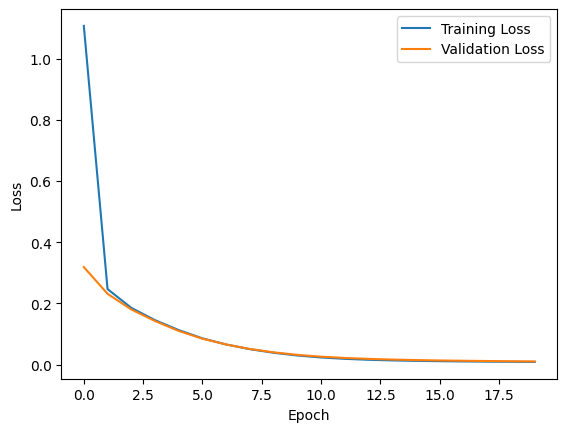

In [13]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Can add RNN layer here)
# Reshape X_train and X_val to fit the RNN layer input shape.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Construct the model & Set the parameters.
input_size = 1  # Number of input features (1 for single sine wave value)
rnn_units = 32  # Number of units in the RNN layer
dense_units = 16  # Number of units in the Dense layer
output_size = 1  # Number of output classes (1 for single sine wave value)

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Flatten())
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.01, batch_size = 16, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For RNN model)
Remember to submit your prediction to Kaggle!

In [14]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###


# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape the X_test to fit RNN layer input shape.
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


# Advance part (35%)






## Accelerometer and Gyroscope dataset
- ⚠⚠ You need to download the training & testing data from Kaggle. ⚠⚠ (Put it into the directory name `Activity data`, or your need to change the path in template.)
- In this dataset, we provide the time-series Accelerometer and Gyroscope data each with 3-axial (x, y, z) (total 6 channels).
- We classified the activity into 3 different classes:
    Activity 1, 2, 3\
    You have to build a RNN model using these time-series data to predict the activity class.
- Steps:
    1. Load the provided `X_train.npy`, `y_train.npy` and `X_test.npy` and split the part of training data to validation.\
    Note: `y_train.npy` is already one-hot encoded.
    2. Visualize the `X_train.npy`.
    3. One-hot encode the `y_train.npy` for three classes: Activity 1, Activity 2, Activity 3.
    4. Build your own RNN model and train it.
    5. Predict with the `X_test.npy` and generate `y_test.csv` then **submit it to Kaggle**!
- We have set 3 baselines on public score:
    * Accuracy >= 0.65 -> 10 points
    * Accuracy >= 0.7  -> 20 points
    * Accuracy >= 0.75 -> 25 points
- Kaggle link: https://www.kaggle.com/t/95e0b11f63e74566802b0dea5ec4f1b4


### 1. Load training & testing data
Load the training and testing data, then split the training data into a validation set using your preferred ratio.

In [15]:
### START CODE HERE ###
# Load X_train, y_train and X_test data
# Change the path if needed
y_train = np.load('Activity data/y_train.npy')
X_train = np.load('Activity data/X_train.npy')
X_test = np.load('Activity data/X_test.npy')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
### END CODE HERE ###

### START CODE HERE ###
# Define the validation ratio in your preferred way
# 1. One-hot encode y_train. (3 classes)
# 2. Split the X_train, y_train data into train & validation set.
validation_ratio = 0.15
num_classes = 3
split_idx = int(X_train.shape[0] * (1 - validation_ratio))
y_train = np.eye(num_classes)[y_train.reshape(-1)]
X_val = X_train[split_idx:]
y_val = y_train[split_idx:]
X_train = X_train[:split_idx]
y_train = y_train[:split_idx]
### END CODE HERE ###



X_train shape: (7352, 128, 6)
y_train shape: (7352, 1)
X_test shape: (2947, 128, 6)


### 2. Visualize the training data

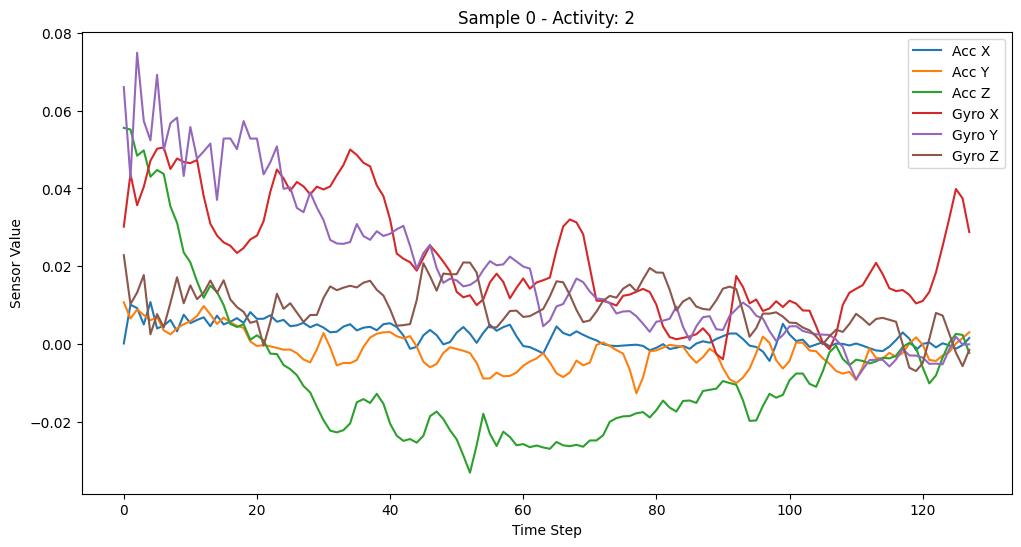

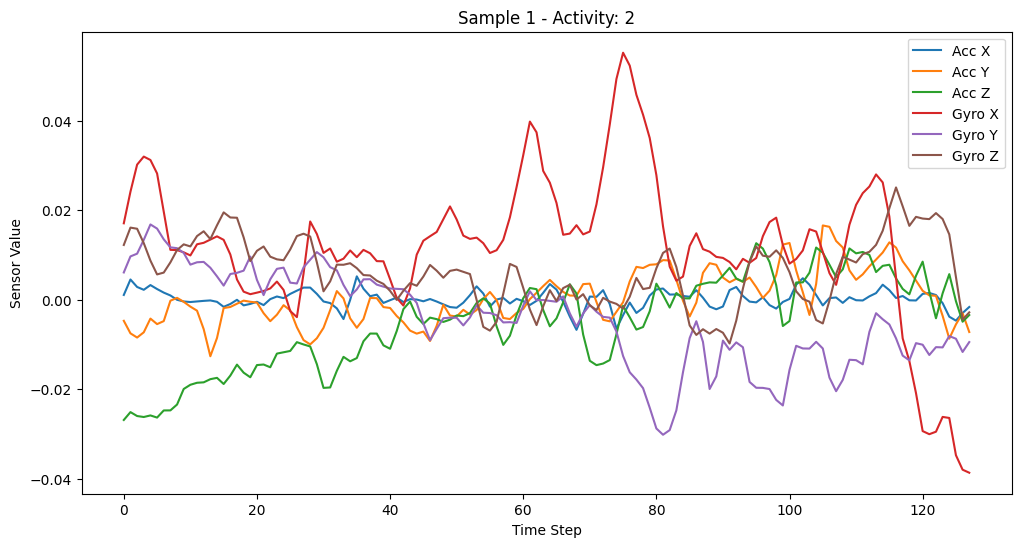

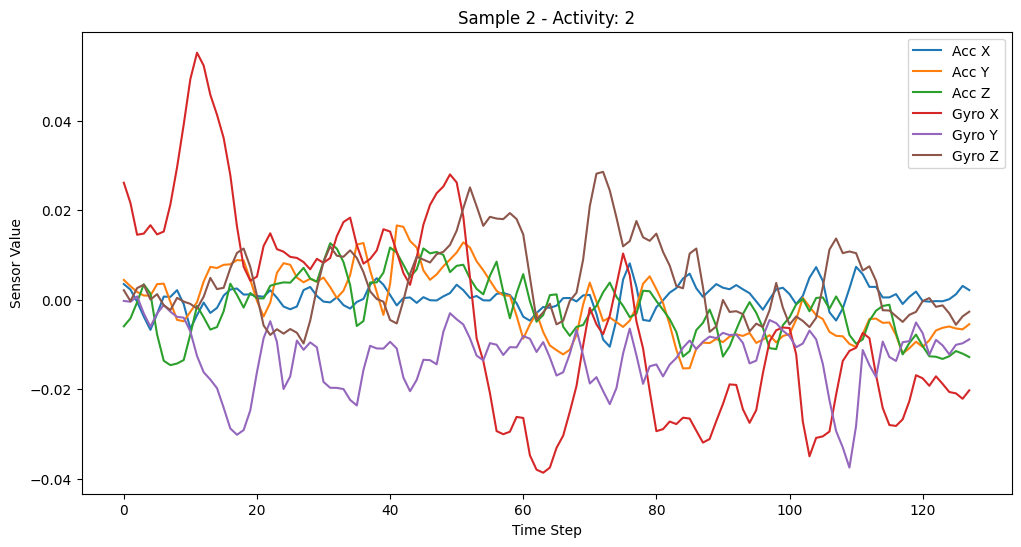

In [16]:
# Function to plot a single sample
def plot_sample(X, y, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(X[sample_index, :, 0], label='Acc X')
    plt.plot(X[sample_index, :, 1], label='Acc Y')
    plt.plot(X[sample_index, :, 2], label='Acc Z')
    plt.plot(X[sample_index, :, 3], label='Gyro X')
    plt.plot(X[sample_index, :, 4], label='Gyro Y')
    plt.plot(X[sample_index, :, 5], label='Gyro Z')
    plt.title(f'Sample {sample_index} - Activity: {np.argmax(y[sample_index])}')
    plt.xlabel('Time Step')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### START CODE HERE ###
# Plot a few samples
for i in range(3):              # Change the range to visualize more samples
    plot_sample(X_train, y_train, i)
 ### END CODE HERE ###

### 3. Contruct and train the model

Epoch 1/200: 100%|██████████| 195/195 [00:01<00:00, 103.28batch/s, loss=1.03]


Epoch 1/200, Training Loss: 1.0409474088492776
Epoch 1/200, Validation Loss: 0.9949438196425638


Epoch 2/200: 100%|██████████| 195/195 [00:01<00:00, 126.79batch/s, loss=0.989]


Epoch 2/200, Training Loss: 0.995258109983229
Epoch 2/200, Validation Loss: 0.9751167478992754


Epoch 3/200: 100%|██████████| 195/195 [00:01<00:00, 145.80batch/s, loss=0.979]


Epoch 3/200, Training Loss: 0.9854623993926761
Epoch 3/200, Validation Loss: 0.9675860436011431


Epoch 4/200: 100%|██████████| 195/195 [00:01<00:00, 146.00batch/s, loss=0.975]


Epoch 4/200, Training Loss: 0.9805967607622615
Epoch 4/200, Validation Loss: 0.962216919031035


Epoch 5/200: 100%|██████████| 195/195 [00:01<00:00, 146.07batch/s, loss=0.97] 


Epoch 5/200, Training Loss: 0.9763754159983686
Epoch 5/200, Validation Loss: 0.9572547561741133


Epoch 6/200: 100%|██████████| 195/195 [00:01<00:00, 131.52batch/s, loss=0.966]


Epoch 6/200, Training Loss: 0.9720752892265281
Epoch 6/200, Validation Loss: 0.9522074165662823


Epoch 7/200: 100%|██████████| 195/195 [00:01<00:00, 153.01batch/s, loss=0.962]


Epoch 7/200, Training Loss: 0.967457670552022
Epoch 7/200, Validation Loss: 0.9468353654690783


Epoch 8/200: 100%|██████████| 195/195 [00:01<00:00, 153.38batch/s, loss=0.957]


Epoch 8/200, Training Loss: 0.9623835494048133
Epoch 8/200, Validation Loss: 0.9409334289288981


Epoch 9/200: 100%|██████████| 195/195 [00:01<00:00, 147.25batch/s, loss=0.951]


Epoch 9/200, Training Loss: 0.9566914166266243
Epoch 9/200, Validation Loss: 0.9343252540275855


Epoch 10/200: 100%|██████████| 195/195 [00:01<00:00, 157.73batch/s, loss=0.944]


Epoch 10/200, Training Loss: 0.9502323102817857
Epoch 10/200, Validation Loss: 0.9267751898149041


Epoch 11/200: 100%|██████████| 195/195 [00:01<00:00, 139.49batch/s, loss=0.937]


Epoch 11/200, Training Loss: 0.9427986929816311
Epoch 11/200, Validation Loss: 0.9180543842159937


Epoch 12/200: 100%|██████████| 195/195 [00:01<00:00, 133.28batch/s, loss=0.928]


Epoch 12/200, Training Loss: 0.93412862706501
Epoch 12/200, Validation Loss: 0.9078102578526575


Epoch 13/200: 100%|██████████| 195/195 [00:01<00:00, 155.17batch/s, loss=0.918]


Epoch 13/200, Training Loss: 0.923908428351241
Epoch 13/200, Validation Loss: 0.8956455523161969


Epoch 14/200: 100%|██████████| 195/195 [00:01<00:00, 148.12batch/s, loss=0.906]


Epoch 14/200, Training Loss: 0.9116682624380281
Epoch 14/200, Validation Loss: 0.8810007534693169


Epoch 15/200: 100%|██████████| 195/195 [00:01<00:00, 131.19batch/s, loss=0.891]


Epoch 15/200, Training Loss: 0.8967418580322076
Epoch 15/200, Validation Loss: 0.8630570700914848


Epoch 16/200: 100%|██████████| 195/195 [00:01<00:00, 105.47batch/s, loss=0.873]


Epoch 16/200, Training Loss: 0.8782294977500761
Epoch 16/200, Validation Loss: 0.8407521788424787


Epoch 17/200: 100%|██████████| 195/195 [00:02<00:00, 92.73batch/s, loss=0.85]  


Epoch 17/200, Training Loss: 0.8546453372615517
Epoch 17/200, Validation Loss: 0.8123673260040244


Epoch 18/200: 100%|██████████| 195/195 [00:02<00:00, 96.99batch/s, loss=0.819] 


Epoch 18/200, Training Loss: 0.8234584016734425
Epoch 18/200, Validation Loss: 0.7751795622147037


Epoch 19/200: 100%|██████████| 195/195 [00:01<00:00, 99.95batch/s, loss=0.777] 


Epoch 19/200, Training Loss: 0.780991602374253
Epoch 19/200, Validation Loss: 0.7266006228202547


Epoch 20/200: 100%|██████████| 195/195 [00:01<00:00, 102.85batch/s, loss=0.72] 


Epoch 20/200, Training Loss: 0.7238597411973354
Epoch 20/200, Validation Loss: 0.6710805475827819


Epoch 21/200: 100%|██████████| 195/195 [00:01<00:00, 102.07batch/s, loss=0.666]


Epoch 21/200, Training Loss: 0.669215850873208
Epoch 21/200, Validation Loss: 0.6356754747643266


Epoch 22/200: 100%|██████████| 195/195 [00:01<00:00, 104.21batch/s, loss=0.643]


Epoch 22/200, Training Loss: 0.6460172540364132
Epoch 22/200, Validation Loss: 0.6187471541071015


Epoch 23/200: 100%|██████████| 195/195 [00:01<00:00, 102.80batch/s, loss=0.632]


Epoch 23/200, Training Loss: 0.6352634249552579
Epoch 23/200, Validation Loss: 0.609100440842747


Epoch 24/200: 100%|██████████| 195/195 [00:01<00:00, 101.18batch/s, loss=0.624]


Epoch 24/200, Training Loss: 0.6275529684561525
Epoch 24/200, Validation Loss: 0.6030211937406448


Epoch 25/200: 100%|██████████| 195/195 [00:03<00:00, 59.10batch/s, loss=0.618]


Epoch 25/200, Training Loss: 0.62107064992877
Epoch 25/200, Validation Loss: 0.5995555580813252


Epoch 26/200: 100%|██████████| 195/195 [00:02<00:00, 85.49batch/s, loss=0.612] 


Epoch 26/200, Training Loss: 0.6155481016017905
Epoch 26/200, Validation Loss: 0.5975442081842074


Epoch 27/200: 100%|██████████| 195/195 [00:02<00:00, 78.22batch/s, loss=0.608]


Epoch 27/200, Training Loss: 0.610966214235476
Epoch 27/200, Validation Loss: 0.5950382899567251


Epoch 28/200: 100%|██████████| 195/195 [00:02<00:00, 88.67batch/s, loss=0.604] 


Epoch 28/200, Training Loss: 0.6071057441877821
Epoch 28/200, Validation Loss: 0.592567239259084


Epoch 29/200: 100%|██████████| 195/195 [00:02<00:00, 92.46batch/s, loss=0.601] 


Epoch 29/200, Training Loss: 0.603849781230513
Epoch 29/200, Validation Loss: 0.592811879896237


Epoch 30/200: 100%|██████████| 195/195 [00:02<00:00, 82.60batch/s, loss=0.598]


Epoch 30/200, Training Loss: 0.6008218358019418
Epoch 30/200, Validation Loss: 0.5905890839725453


Epoch 31/200: 100%|██████████| 195/195 [00:01<00:00, 106.49batch/s, loss=0.595]


Epoch 31/200, Training Loss: 0.5982467175432543
Epoch 31/200, Validation Loss: 0.5887807381176519


Epoch 32/200: 100%|██████████| 195/195 [00:01<00:00, 107.35batch/s, loss=0.593]


Epoch 32/200, Training Loss: 0.5959510714757535
Epoch 32/200, Validation Loss: 0.5870974284611162


Epoch 33/200: 100%|██████████| 195/195 [00:02<00:00, 87.56batch/s, loss=0.591]


Epoch 33/200, Training Loss: 0.5937989354830109
Epoch 33/200, Validation Loss: 0.585818108760087


Epoch 34/200: 100%|██████████| 195/195 [00:02<00:00, 89.33batch/s, loss=0.589] 


Epoch 34/200, Training Loss: 0.591918805100666
Epoch 34/200, Validation Loss: 0.5843382580433057


Epoch 35/200: 100%|██████████| 195/195 [00:01<00:00, 99.93batch/s, loss=0.587] 


Epoch 35/200, Training Loss: 0.59020752523918
Epoch 35/200, Validation Loss: 0.5827056178387514


Epoch 36/200: 100%|██████████| 195/195 [00:02<00:00, 83.39batch/s, loss=0.586]


Epoch 36/200, Training Loss: 0.5886585886989267
Epoch 36/200, Validation Loss: 0.581381034563399


Epoch 37/200: 100%|██████████| 195/195 [00:02<00:00, 93.34batch/s, loss=0.584] 


Epoch 37/200, Training Loss: 0.5872336054648859
Epoch 37/200, Validation Loss: 0.5805751378885329


Epoch 38/200: 100%|██████████| 195/195 [00:02<00:00, 96.49batch/s, loss=0.583] 


Epoch 38/200, Training Loss: 0.5858034674430187
Epoch 38/200, Validation Loss: 0.5796115710395565


Epoch 39/200: 100%|██████████| 195/195 [00:02<00:00, 88.32batch/s, loss=0.582]


Epoch 39/200, Training Loss: 0.5846534165331216
Epoch 39/200, Validation Loss: 0.5777530846639108


Epoch 40/200: 100%|██████████| 195/195 [00:02<00:00, 90.42batch/s, loss=0.58]  


Epoch 40/200, Training Loss: 0.5833824212196175
Epoch 40/200, Validation Loss: 0.5764068310933708


Epoch 41/200: 100%|██████████| 195/195 [00:01<00:00, 99.86batch/s, loss=0.579] 


Epoch 41/200, Training Loss: 0.5822270105247498
Epoch 41/200, Validation Loss: 0.575719693458234


Epoch 42/200: 100%|██████████| 195/195 [00:02<00:00, 89.37batch/s, loss=0.578]


Epoch 42/200, Training Loss: 0.5810673532551266
Epoch 42/200, Validation Loss: 0.5747625238865819


Epoch 43/200: 100%|██████████| 195/195 [00:02<00:00, 74.66batch/s, loss=0.577] 


Epoch 43/200, Training Loss: 0.5800579981416859
Epoch 43/200, Validation Loss: 0.5738098810922999


Epoch 44/200: 100%|██████████| 195/195 [00:01<00:00, 101.61batch/s, loss=0.576]


Epoch 44/200, Training Loss: 0.5788820334527581
Epoch 44/200, Validation Loss: 0.5728587470791442


Epoch 45/200: 100%|██████████| 195/195 [00:02<00:00, 86.00batch/s, loss=0.575]


Epoch 45/200, Training Loss: 0.5779117376442129
Epoch 45/200, Validation Loss: 0.5721486177062582


Epoch 46/200: 100%|██████████| 195/195 [00:02<00:00, 87.10batch/s, loss=0.574] 


Epoch 46/200, Training Loss: 0.5770789422278696
Epoch 46/200, Validation Loss: 0.5715604363091034


Epoch 47/200: 100%|██████████| 195/195 [00:01<00:00, 103.33batch/s, loss=0.573]


Epoch 47/200, Training Loss: 0.5764324876133484
Epoch 47/200, Validation Loss: 0.5708081856485899


Epoch 48/200: 100%|██████████| 195/195 [00:02<00:00, 81.34batch/s, loss=0.572]


Epoch 48/200, Training Loss: 0.5754332039457215
Epoch 48/200, Validation Loss: 0.5702853183385664


Epoch 49/200: 100%|██████████| 195/195 [00:02<00:00, 88.19batch/s, loss=0.572] 


Epoch 49/200, Training Loss: 0.5747501339285723
Epoch 49/200, Validation Loss: 0.5692359014182777


Epoch 50/200: 100%|██████████| 195/195 [00:01<00:00, 99.09batch/s, loss=0.571] 


Epoch 50/200, Training Loss: 0.5739699364465592
Epoch 50/200, Validation Loss: 0.5687659691133727


Epoch 51/200: 100%|██████████| 195/195 [00:02<00:00, 95.00batch/s, loss=0.57]  


Epoch 51/200, Training Loss: 0.573226315158705
Epoch 51/200, Validation Loss: 0.567868612174417


Epoch 52/200: 100%|██████████| 195/195 [00:02<00:00, 91.15batch/s, loss=0.569] 


Epoch 52/200, Training Loss: 0.5725860581415221
Epoch 52/200, Validation Loss: 0.5674757843240285


Epoch 53/200: 100%|██████████| 195/195 [00:02<00:00, 91.92batch/s, loss=0.569] 


Epoch 53/200, Training Loss: 0.5719759064040415
Epoch 53/200, Validation Loss: 0.5670104672177875


Epoch 54/200: 100%|██████████| 195/195 [00:02<00:00, 97.34batch/s, loss=0.568] 


Epoch 54/200, Training Loss: 0.5712872323637392
Epoch 54/200, Validation Loss: 0.5662626480972637


Epoch 55/200: 100%|██████████| 195/195 [00:02<00:00, 84.07batch/s, loss=0.568] 


Epoch 55/200, Training Loss: 0.5706657531754793
Epoch 55/200, Validation Loss: 0.5658195088228688


Epoch 56/200: 100%|██████████| 195/195 [00:02<00:00, 76.78batch/s, loss=0.567] 


Epoch 56/200, Training Loss: 0.5699699563998246
Epoch 56/200, Validation Loss: 0.5653481722286428


Epoch 57/200: 100%|██████████| 195/195 [00:02<00:00, 80.64batch/s, loss=0.566] 


Epoch 57/200, Training Loss: 0.5693853313587054
Epoch 57/200, Validation Loss: 0.5657883252087118


Epoch 58/200: 100%|██████████| 195/195 [00:02<00:00, 85.82batch/s, loss=0.566]


Epoch 58/200, Training Loss: 0.5687296937928771
Epoch 58/200, Validation Loss: 0.5649668165244327


Epoch 59/200: 100%|██████████| 195/195 [00:02<00:00, 96.41batch/s, loss=0.565] 


Epoch 59/200, Training Loss: 0.5681110724001158
Epoch 59/200, Validation Loss: 0.5646475194753887


Epoch 60/200: 100%|██████████| 195/195 [00:02<00:00, 80.48batch/s, loss=0.564]


Epoch 60/200, Training Loss: 0.567472985246917
Epoch 60/200, Validation Loss: 0.5647079871208277


Epoch 61/200: 100%|██████████| 195/195 [00:02<00:00, 79.05batch/s, loss=0.564]


Epoch 61/200, Training Loss: 0.5667402102045912
Epoch 61/200, Validation Loss: 0.5641821137877532


Epoch 62/200: 100%|██████████| 195/195 [00:01<00:00, 109.93batch/s, loss=0.563]


Epoch 62/200, Training Loss: 0.5662601239596399
Epoch 62/200, Validation Loss: 0.5647316335307895


Epoch 63/200: 100%|██████████| 195/195 [00:02<00:00, 77.46batch/s, loss=0.562]


Epoch 63/200, Training Loss: 0.5656343979954868
Epoch 63/200, Validation Loss: 0.5657439872219528


Epoch 64/200: 100%|██████████| 195/195 [00:01<00:00, 99.96batch/s, loss=0.562] 


Epoch 64/200, Training Loss: 0.5648413304301689
Epoch 64/200, Validation Loss: 0.5648620493171452


Epoch 65/200: 100%|██████████| 195/195 [00:02<00:00, 84.27batch/s, loss=0.561]


Epoch 65/200, Training Loss: 0.5638907769000904
Epoch 65/200, Validation Loss: 0.5650371767724404


Epoch 66/200: 100%|██████████| 195/195 [00:02<00:00, 82.63batch/s, loss=0.56] 


Epoch 66/200, Training Loss: 0.5630971265262938
Epoch 66/200, Validation Loss: 0.5641206550991854


Epoch 67/200: 100%|██████████| 195/195 [00:02<00:00, 88.70batch/s, loss=0.559] 


Epoch 67/200, Training Loss: 0.5620808336196609
Epoch 67/200, Validation Loss: 0.5642631006452283


Epoch 68/200: 100%|██████████| 195/195 [00:02<00:00, 79.32batch/s, loss=0.558]


Epoch 68/200, Training Loss: 0.561133338672753
Epoch 68/200, Validation Loss: 0.5641271322081518


Epoch 69/200: 100%|██████████| 195/195 [00:02<00:00, 88.49batch/s, loss=0.557]


Epoch 69/200, Training Loss: 0.5600280876803392
Epoch 69/200, Validation Loss: 0.5637515229715659


Epoch 70/200: 100%|██████████| 195/195 [00:02<00:00, 83.20batch/s, loss=0.556]


Epoch 70/200, Training Loss: 0.558823487318524
Epoch 70/200, Validation Loss: 0.5632929777508228


Epoch 71/200: 100%|██████████| 195/195 [00:02<00:00, 85.40batch/s, loss=0.554] 


Epoch 71/200, Training Loss: 0.5574670175225345
Epoch 71/200, Validation Loss: 0.563139309730447


Epoch 72/200: 100%|██████████| 195/195 [00:02<00:00, 97.18batch/s, loss=0.553] 


Epoch 72/200, Training Loss: 0.5560935843884378
Epoch 72/200, Validation Loss: 0.5630595072686936


Epoch 73/200: 100%|██████████| 195/195 [00:02<00:00, 88.44batch/s, loss=0.552] 


Epoch 73/200, Training Loss: 0.5551430101387206
Epoch 73/200, Validation Loss: 0.55966701552539


Epoch 74/200: 100%|██████████| 195/195 [00:02<00:00, 86.88batch/s, loss=0.551] 


Epoch 74/200, Training Loss: 0.5542050744258181
Epoch 74/200, Validation Loss: 0.5581704944825479


Epoch 75/200: 100%|██████████| 195/195 [00:02<00:00, 96.67batch/s, loss=0.55]  


Epoch 75/200, Training Loss: 0.5530906053840186
Epoch 75/200, Validation Loss: 0.5575298722074025


Epoch 76/200: 100%|██████████| 195/195 [00:02<00:00, 80.39batch/s, loss=0.549] 


Epoch 76/200, Training Loss: 0.5519431035265785
Epoch 76/200, Validation Loss: 0.5574679137209357


Epoch 77/200: 100%|██████████| 195/195 [00:02<00:00, 88.56batch/s, loss=0.548] 


Epoch 77/200, Training Loss: 0.5509327266246172
Epoch 77/200, Validation Loss: 0.5551715645431741


Epoch 78/200: 100%|██████████| 195/195 [00:02<00:00, 95.68batch/s, loss=0.546] 


Epoch 78/200, Training Loss: 0.549544839455833
Epoch 78/200, Validation Loss: 0.5547695146143701


Epoch 79/200: 100%|██████████| 195/195 [00:02<00:00, 86.52batch/s, loss=0.545]


Epoch 79/200, Training Loss: 0.5481174455086956
Epoch 79/200, Validation Loss: 0.5544931860618992


Epoch 80/200: 100%|██████████| 195/195 [00:02<00:00, 93.19batch/s, loss=0.543] 


Epoch 80/200, Training Loss: 0.5464690111594223
Epoch 80/200, Validation Loss: 0.5538913163805383


Epoch 81/200: 100%|██████████| 195/195 [00:01<00:00, 105.01batch/s, loss=0.534]


Epoch 81/200, Training Loss: 0.5378828919841033
Epoch 81/200, Validation Loss: 0.5396209974410627


Epoch 82/200: 100%|██████████| 195/195 [00:02<00:00, 93.18batch/s, loss=0.533] 


Epoch 82/200, Training Loss: 0.5369854270113665
Epoch 82/200, Validation Loss: 0.5391416821448661


Epoch 83/200: 100%|██████████| 195/195 [00:02<00:00, 81.34batch/s, loss=0.533] 


Epoch 83/200, Training Loss: 0.5362766678114771
Epoch 83/200, Validation Loss: 0.5385706970945456


Epoch 84/200: 100%|██████████| 195/195 [00:01<00:00, 108.85batch/s, loss=0.532]


Epoch 84/200, Training Loss: 0.5354677846185362
Epoch 84/200, Validation Loss: 0.537792260953068


Epoch 85/200: 100%|██████████| 195/195 [00:02<00:00, 93.01batch/s, loss=0.531] 


Epoch 85/200, Training Loss: 0.5347020520796792
Epoch 85/200, Validation Loss: 0.5371007613597608


Epoch 86/200: 100%|██████████| 195/195 [00:02<00:00, 85.06batch/s, loss=0.53] 


Epoch 86/200, Training Loss: 0.5338370616044337
Epoch 86/200, Validation Loss: 0.5360754497292306


Epoch 87/200: 100%|██████████| 195/195 [00:01<00:00, 104.06batch/s, loss=0.529]


Epoch 87/200, Training Loss: 0.532966590539446
Epoch 87/200, Validation Loss: 0.5352434392288579


Epoch 88/200: 100%|██████████| 195/195 [00:02<00:00, 81.88batch/s, loss=0.528]


Epoch 88/200, Training Loss: 0.5321757172773477
Epoch 88/200, Validation Loss: 0.5343862012641798


Epoch 89/200: 100%|██████████| 195/195 [00:02<00:00, 96.45batch/s, loss=0.528] 


Epoch 89/200, Training Loss: 0.5313719974850506
Epoch 89/200, Validation Loss: 0.5335846061173536


Epoch 90/200: 100%|██████████| 195/195 [00:01<00:00, 104.88batch/s, loss=0.527]


Epoch 90/200, Training Loss: 0.5304028199700244
Epoch 90/200, Validation Loss: 0.5324456162855775


Epoch 91/200: 100%|██████████| 195/195 [00:02<00:00, 77.72batch/s, loss=0.526]


Epoch 91/200, Training Loss: 0.5294736378844813
Epoch 91/200, Validation Loss: 0.5315940375921292


Epoch 92/200: 100%|██████████| 195/195 [00:02<00:00, 94.42batch/s, loss=0.525] 


Epoch 92/200, Training Loss: 0.528443484213494
Epoch 92/200, Validation Loss: 0.5303975979753867


Epoch 93/200: 100%|██████████| 195/195 [00:01<00:00, 101.81batch/s, loss=0.523]


Epoch 93/200, Training Loss: 0.5271838313073888
Epoch 93/200, Validation Loss: 0.5289928340293584


Epoch 94/200: 100%|██████████| 195/195 [00:02<00:00, 90.68batch/s, loss=0.522]


Epoch 94/200, Training Loss: 0.5259997365131626
Epoch 94/200, Validation Loss: 0.5277823409280002


Epoch 95/200: 100%|██████████| 195/195 [00:02<00:00, 91.04batch/s, loss=0.521] 


Epoch 95/200, Training Loss: 0.5245921423450184
Epoch 95/200, Validation Loss: 0.5263294828990921


Epoch 96/200: 100%|██████████| 195/195 [00:01<00:00, 101.80batch/s, loss=0.519]


Epoch 96/200, Training Loss: 0.5229782977331765
Epoch 96/200, Validation Loss: 0.5247031349356389


Epoch 97/200: 100%|██████████| 195/195 [00:02<00:00, 89.72batch/s, loss=0.518]


Epoch 97/200, Training Loss: 0.5214873848273938
Epoch 97/200, Validation Loss: 0.522833833673788


Epoch 98/200: 100%|██████████| 195/195 [00:02<00:00, 86.76batch/s, loss=0.516] 


Epoch 98/200, Training Loss: 0.5196783742430724
Epoch 98/200, Validation Loss: 0.5208081524514494


Epoch 99/200: 100%|██████████| 195/195 [00:01<00:00, 103.66batch/s, loss=0.514]


Epoch 99/200, Training Loss: 0.5177312410772511
Epoch 99/200, Validation Loss: 0.5187677473872386


Epoch 100/200: 100%|██████████| 195/195 [00:02<00:00, 94.04batch/s, loss=0.512] 


Epoch 100/200, Training Loss: 0.5157145769401045
Epoch 100/200, Validation Loss: 0.5165020972808556


Epoch 101/200: 100%|██████████| 195/195 [00:02<00:00, 87.02batch/s, loss=0.509]


Epoch 101/200, Training Loss: 0.5132157959100827
Epoch 101/200, Validation Loss: 0.5140315115036973


Epoch 102/200: 100%|██████████| 195/195 [00:01<00:00, 105.35batch/s, loss=0.507]


Epoch 102/200, Training Loss: 0.5106395352980916
Epoch 102/200, Validation Loss: 0.5115159238625271


Epoch 103/200: 100%|██████████| 195/195 [00:02<00:00, 95.64batch/s, loss=0.504] 


Epoch 103/200, Training Loss: 0.5077727465582617
Epoch 103/200, Validation Loss: 0.50886276735438


Epoch 104/200: 100%|██████████| 195/195 [00:02<00:00, 89.76batch/s, loss=0.501] 


Epoch 104/200, Training Loss: 0.5047281737135053
Epoch 104/200, Validation Loss: 0.5061826163356568


Epoch 105/200: 100%|██████████| 195/195 [00:01<00:00, 110.13batch/s, loss=0.497]


Epoch 105/200, Training Loss: 0.5012181556256957
Epoch 105/200, Validation Loss: 0.5040360567833395


Epoch 106/200: 100%|██████████| 195/195 [00:02<00:00, 90.74batch/s, loss=0.493] 


Epoch 106/200, Training Loss: 0.49712748851968785
Epoch 106/200, Validation Loss: 0.5029214295678153


Epoch 107/200: 100%|██████████| 195/195 [00:02<00:00, 93.28batch/s, loss=0.489] 


Epoch 107/200, Training Loss: 0.49285514824861
Epoch 107/200, Validation Loss: 0.5025227166498173


Epoch 108/200: 100%|██████████| 195/195 [00:02<00:00, 85.28batch/s, loss=0.484] 


Epoch 108/200, Training Loss: 0.4878964751194709
Epoch 108/200, Validation Loss: 0.49992663565448175


Epoch 109/200: 100%|██████████| 195/195 [00:02<00:00, 78.83batch/s, loss=0.479]


Epoch 109/200, Training Loss: 0.482765774004635
Epoch 109/200, Validation Loss: 0.49672320989058677


Epoch 110/200: 100%|██████████| 195/195 [00:02<00:00, 77.70batch/s, loss=0.474]


Epoch 110/200, Training Loss: 0.47751933562426435
Epoch 110/200, Validation Loss: 0.4923385880794539


Epoch 111/200: 100%|██████████| 195/195 [00:02<00:00, 95.56batch/s, loss=0.468] 


Epoch 111/200, Training Loss: 0.4716346943095516
Epoch 111/200, Validation Loss: 0.48744068213551933


Epoch 112/200: 100%|██████████| 195/195 [00:02<00:00, 96.68batch/s, loss=0.462] 


Epoch 112/200, Training Loss: 0.4657474394587403
Epoch 112/200, Validation Loss: 0.48372755952228763


Epoch 113/200: 100%|██████████| 195/195 [00:02<00:00, 68.60batch/s, loss=0.456] 


Epoch 113/200, Training Loss: 0.45926198733864904
Epoch 113/200, Validation Loss: 0.47857430066254814


Epoch 114/200: 100%|██████████| 195/195 [00:02<00:00, 88.27batch/s, loss=0.451]


Epoch 114/200, Training Loss: 0.4538056940429873
Epoch 114/200, Validation Loss: 0.47395983496576466


Epoch 115/200: 100%|██████████| 195/195 [00:02<00:00, 78.95batch/s, loss=0.445]


Epoch 115/200, Training Loss: 0.44816197526574425
Epoch 115/200, Validation Loss: 0.47034222999295355


Epoch 116/200: 100%|██████████| 195/195 [00:02<00:00, 79.22batch/s, loss=0.442]


Epoch 116/200, Training Loss: 0.4449945937661227
Epoch 116/200, Validation Loss: 0.467144618334502


Epoch 117/200: 100%|██████████| 195/195 [00:02<00:00, 93.12batch/s, loss=0.437] 


Epoch 117/200, Training Loss: 0.43987175679444435
Epoch 117/200, Validation Loss: 0.46360270634075623


Epoch 118/200: 100%|██████████| 195/195 [00:02<00:00, 79.47batch/s, loss=0.433]


Epoch 118/200, Training Loss: 0.43590323587574803
Epoch 118/200, Validation Loss: 0.4620257615887344


Epoch 119/200: 100%|██████████| 195/195 [00:02<00:00, 94.51batch/s, loss=0.43] 


Epoch 119/200, Training Loss: 0.4333427654386495
Epoch 119/200, Validation Loss: 0.46109489911319795


Epoch 120/200: 100%|██████████| 195/195 [00:02<00:00, 90.15batch/s, loss=0.427] 


Epoch 120/200, Training Loss: 0.43013036842872376
Epoch 120/200, Validation Loss: 0.4580239651336756


Epoch 121/200: 100%|██████████| 195/195 [00:02<00:00, 92.85batch/s, loss=0.427] 


Epoch 121/200, Training Loss: 0.42946651602582986
Epoch 121/200, Validation Loss: 0.45193939835146724


Epoch 122/200: 100%|██████████| 195/195 [00:02<00:00, 95.52batch/s, loss=0.424] 


Epoch 122/200, Training Loss: 0.4269617565167543
Epoch 122/200, Validation Loss: 0.4484686193542615


Epoch 123/200: 100%|██████████| 195/195 [00:02<00:00, 83.26batch/s, loss=0.419]


Epoch 123/200, Training Loss: 0.42206032385078485
Epoch 123/200, Validation Loss: 0.4411735998970266


Epoch 124/200: 100%|██████████| 195/195 [00:02<00:00, 83.57batch/s, loss=0.423]


Epoch 124/200, Training Loss: 0.426137303884229
Epoch 124/200, Validation Loss: 0.43529517830601


Epoch 125/200: 100%|██████████| 195/195 [00:02<00:00, 81.49batch/s, loss=0.418]


Epoch 125/200, Training Loss: 0.4206811205799614
Epoch 125/200, Validation Loss: 0.43245734236203126


Epoch 126/200: 100%|██████████| 195/195 [00:02<00:00, 93.48batch/s, loss=0.41]  


Epoch 126/200, Training Loss: 0.4127114138346732
Epoch 126/200, Validation Loss: 0.42652607225217076


Epoch 127/200: 100%|██████████| 195/195 [00:02<00:00, 75.39batch/s, loss=0.402] 


Epoch 127/200, Training Loss: 0.40457362822068565
Epoch 127/200, Validation Loss: 0.4190607768711466


Epoch 128/200: 100%|██████████| 195/195 [00:02<00:00, 93.58batch/s, loss=0.394] 


Epoch 128/200, Training Loss: 0.39687027164824223
Epoch 128/200, Validation Loss: 0.4115146905615676


Epoch 129/200: 100%|██████████| 195/195 [00:03<00:00, 62.81batch/s, loss=0.387]


Epoch 129/200, Training Loss: 0.38928400456597656
Epoch 129/200, Validation Loss: 0.40617320275502494


Epoch 130/200: 100%|██████████| 195/195 [00:01<00:00, 100.02batch/s, loss=0.382]


Epoch 130/200, Training Loss: 0.3845947076662671
Epoch 130/200, Validation Loss: 0.39925621628403607


Epoch 131/200: 100%|██████████| 195/195 [00:01<00:00, 101.62batch/s, loss=0.374]


Epoch 131/200, Training Loss: 0.376518992959633
Epoch 131/200, Validation Loss: 0.3975303568388879


Epoch 132/200: 100%|██████████| 195/195 [00:02<00:00, 79.00batch/s, loss=0.37] 


Epoch 132/200, Training Loss: 0.37248920248910616
Epoch 132/200, Validation Loss: 0.3939900962748934


Epoch 133/200: 100%|██████████| 195/195 [00:02<00:00, 90.59batch/s, loss=0.366] 


Epoch 133/200, Training Loss: 0.3681078298275816
Epoch 133/200, Validation Loss: 0.3841775374432752


Epoch 134/200: 100%|██████████| 195/195 [00:01<00:00, 104.24batch/s, loss=0.364]


Epoch 134/200, Training Loss: 0.36626500956283214
Epoch 134/200, Validation Loss: 0.3801739818696087


Epoch 135/200: 100%|██████████| 195/195 [00:02<00:00, 80.37batch/s, loss=0.363]


Epoch 135/200, Training Loss: 0.3652494326009194
Epoch 135/200, Validation Loss: 0.3813862093916954


Epoch 136/200: 100%|██████████| 195/195 [00:02<00:00, 97.29batch/s, loss=0.361] 


Epoch 136/200, Training Loss: 0.3636097495708827
Epoch 136/200, Validation Loss: 0.3797285550243785


Epoch 137/200: 100%|██████████| 195/195 [00:01<00:00, 108.06batch/s, loss=0.359]


Epoch 137/200, Training Loss: 0.3617038998253044
Epoch 137/200, Validation Loss: 0.37976997658489375


Epoch 138/200: 100%|██████████| 195/195 [00:02<00:00, 78.11batch/s, loss=0.361]


Epoch 138/200, Training Loss: 0.3647577616065389
Epoch 138/200, Validation Loss: 0.39214192933513914


Epoch 139/200: 100%|██████████| 195/195 [00:02<00:00, 97.03batch/s, loss=0.366] 


Epoch 139/200, Training Loss: 0.36801385786653223
Epoch 139/200, Validation Loss: 0.3816304837830321


Epoch 140/200: 100%|██████████| 195/195 [00:01<00:00, 114.97batch/s, loss=0.359]


Epoch 140/200, Training Loss: 0.36121933354993024
Epoch 140/200, Validation Loss: 0.37553303358815626


Epoch 141/200: 100%|██████████| 195/195 [00:02<00:00, 78.56batch/s, loss=0.356]


Epoch 141/200, Training Loss: 0.358774452085493
Epoch 141/200, Validation Loss: 0.3803624279753372


Epoch 142/200: 100%|██████████| 195/195 [00:02<00:00, 85.60batch/s, loss=0.357] 


Epoch 142/200, Training Loss: 0.3595681988644149
Epoch 142/200, Validation Loss: 0.3752900900091375


Epoch 143/200: 100%|██████████| 195/195 [00:01<00:00, 98.42batch/s, loss=0.352] 


Epoch 143/200, Training Loss: 0.35461489727677026
Epoch 143/200, Validation Loss: 0.3697489712696306


Epoch 144/200: 100%|██████████| 195/195 [00:02<00:00, 84.47batch/s, loss=0.355]


Epoch 144/200, Training Loss: 0.3570160952324679
Epoch 144/200, Validation Loss: 0.37083229760045705


Epoch 145/200: 100%|██████████| 195/195 [00:02<00:00, 91.69batch/s, loss=0.352] 


Epoch 145/200, Training Loss: 0.3546852515648497
Epoch 145/200, Validation Loss: 0.35629471969822696


Epoch 146/200: 100%|██████████| 195/195 [00:02<00:00, 95.94batch/s, loss=0.354] 


Epoch 146/200, Training Loss: 0.3570689610032071
Epoch 146/200, Validation Loss: 0.35237227541033556


Epoch 147/200: 100%|██████████| 195/195 [00:02<00:00, 94.22batch/s, loss=0.351] 


Epoch 147/200, Training Loss: 0.3538014796771503
Epoch 147/200, Validation Loss: 0.35162979161430663


Epoch 148/200: 100%|██████████| 195/195 [00:02<00:00, 90.00batch/s, loss=0.376] 


Epoch 148/200, Training Loss: 0.3792739759973983
Epoch 148/200, Validation Loss: 0.36431829561882034


Epoch 149/200: 100%|██████████| 195/195 [00:02<00:00, 95.28batch/s, loss=0.353] 


Epoch 149/200, Training Loss: 0.355514590208406
Epoch 149/200, Validation Loss: 0.3557158696116714


Epoch 150/200: 100%|██████████| 195/195 [00:02<00:00, 83.37batch/s, loss=0.35] 


Epoch 150/200, Training Loss: 0.35346689897483696
Epoch 150/200, Validation Loss: 0.3572359664403629


Epoch 151/200: 100%|██████████| 195/195 [00:01<00:00, 100.38batch/s, loss=0.348]


Epoch 151/200, Training Loss: 0.3511821844725529
Epoch 151/200, Validation Loss: 0.35814428924301706


Epoch 152/200: 100%|██████████| 195/195 [00:01<00:00, 104.25batch/s, loss=0.344]


Epoch 152/200, Training Loss: 0.346623938644594
Epoch 152/200, Validation Loss: 0.34985211012023826


Epoch 153/200: 100%|██████████| 195/195 [00:02<00:00, 83.01batch/s, loss=0.341]


Epoch 153/200, Training Loss: 0.3442115796614047
Epoch 153/200, Validation Loss: 0.345218402059897


Epoch 154/200: 100%|██████████| 195/195 [00:02<00:00, 85.87batch/s, loss=0.802] 


Epoch 154/200, Training Loss: 0.8050651122941701
Epoch 154/200, Validation Loss: 0.9416180632424758


Epoch 155/200: 100%|██████████| 195/195 [00:02<00:00, 69.80batch/s, loss=0.827]


Epoch 155/200, Training Loss: 0.8303079292595993
Epoch 155/200, Validation Loss: 0.7710721974711402


Epoch 156/200: 100%|██████████| 195/195 [00:02<00:00, 88.18batch/s, loss=0.732] 


Epoch 156/200, Training Loss: 0.7349448347449897
Epoch 156/200, Validation Loss: 0.6874350858798203


Epoch 157/200: 100%|██████████| 195/195 [00:02<00:00, 81.10batch/s, loss=0.655] 


Epoch 157/200, Training Loss: 0.6578516578151384
Epoch 157/200, Validation Loss: 0.6112892602619778


Epoch 158/200: 100%|██████████| 195/195 [00:01<00:00, 99.67batch/s, loss=0.581] 


Epoch 158/200, Training Loss: 0.5832763256251909
Epoch 158/200, Validation Loss: 0.5374565547141398


Epoch 159/200: 100%|██████████| 195/195 [00:02<00:00, 69.56batch/s, loss=0.51] 


Epoch 159/200, Training Loss: 0.512612327722383
Epoch 159/200, Validation Loss: 0.48066746415882483


Epoch 160/200: 100%|██████████| 195/195 [00:02<00:00, 86.13batch/s, loss=0.464] 


Epoch 160/200, Training Loss: 0.46681478405826976
Epoch 160/200, Validation Loss: 0.4426154273478348


Epoch 161/200: 100%|██████████| 195/195 [00:02<00:00, 87.69batch/s, loss=0.447]


Epoch 161/200, Training Loss: 0.4492404431213607
Epoch 161/200, Validation Loss: 0.4461547809807925


Epoch 162/200: 100%|██████████| 195/195 [00:02<00:00, 81.53batch/s, loss=0.431] 


Epoch 162/200, Training Loss: 0.43322330754801297
Epoch 162/200, Validation Loss: 0.42337713688512274


Epoch 163/200: 100%|██████████| 195/195 [00:02<00:00, 87.61batch/s, loss=0.417]


Epoch 163/200, Training Loss: 0.42006405570678573
Epoch 163/200, Validation Loss: 0.41839842053147575


Epoch 164/200: 100%|██████████| 195/195 [00:02<00:00, 92.23batch/s, loss=0.413] 


Epoch 164/200, Training Loss: 0.4155292197871771
Epoch 164/200, Validation Loss: 0.4099567316563849


Epoch 165/200: 100%|██████████| 195/195 [00:02<00:00, 75.42batch/s, loss=0.408]


Epoch 165/200, Training Loss: 0.4107953776483311
Epoch 165/200, Validation Loss: 0.4025035105490542


Epoch 166/200: 100%|██████████| 195/195 [00:02<00:00, 92.83batch/s, loss=0.406] 


Epoch 166/200, Training Loss: 0.40821200225169746
Epoch 166/200, Validation Loss: 0.41529831791257626


Epoch 167/200: 100%|██████████| 195/195 [00:02<00:00, 84.21batch/s, loss=0.41] 


Epoch 167/200, Training Loss: 0.4120772869901643
Epoch 167/200, Validation Loss: 0.40425494126040806


Epoch 168/200: 100%|██████████| 195/195 [00:02<00:00, 87.67batch/s, loss=0.401] 


Epoch 168/200, Training Loss: 0.40326289182749825
Epoch 168/200, Validation Loss: 0.40664862772901067


Epoch 169/200: 100%|██████████| 195/195 [00:01<00:00, 101.30batch/s, loss=0.407]


Epoch 169/200, Training Loss: 0.4093218062423921
Epoch 169/200, Validation Loss: 0.39889047050262516


Epoch 170/200: 100%|██████████| 195/195 [00:02<00:00, 77.96batch/s, loss=0.395]


Epoch 170/200, Training Loss: 0.3977684727720359
Epoch 170/200, Validation Loss: 0.3930850479707994


Epoch 171/200: 100%|██████████| 195/195 [00:02<00:00, 84.74batch/s, loss=0.416]


Epoch 171/200, Training Loss: 0.4187888786046839
Epoch 171/200, Validation Loss: 0.4026623766123373


Epoch 172/200: 100%|██████████| 195/195 [00:02<00:00, 95.01batch/s, loss=0.388]


Epoch 172/200, Training Loss: 0.39026224043090507
Epoch 172/200, Validation Loss: 0.38080935042332453


Epoch 173/200: 100%|██████████| 195/195 [00:02<00:00, 83.60batch/s, loss=0.378]


Epoch 173/200, Training Loss: 0.380329880307691
Epoch 173/200, Validation Loss: 0.3778577380196557


Epoch 174/200: 100%|██████████| 195/195 [00:02<00:00, 83.75batch/s, loss=1.94]


Epoch 174/200, Training Loss: 1.9477312417170076
Epoch 174/200, Validation Loss: 1.1831282662399687


Epoch 175/200: 100%|██████████| 195/195 [00:02<00:00, 95.95batch/s, loss=1.14]


Epoch 175/200, Training Loss: 1.1467713065438208
Epoch 175/200, Validation Loss: 1.0939988196853727


Epoch 176/200: 100%|██████████| 195/195 [00:02<00:00, 73.82batch/s, loss=1.1] 


Epoch 176/200, Training Loss: 1.1037082940325207
Epoch 176/200, Validation Loss: 1.0663680721639759


Epoch 177/200: 100%|██████████| 195/195 [00:02<00:00, 92.86batch/s, loss=1.07] 


Epoch 177/200, Training Loss: 1.0816551738443942
Epoch 177/200, Validation Loss: 1.0527240648302554


Epoch 178/200: 100%|██████████| 195/195 [00:02<00:00, 84.75batch/s, loss=1.07]


Epoch 178/200, Training Loss: 1.077238264511324
Epoch 178/200, Validation Loss: 1.0324545176250408


Epoch 179/200: 100%|██████████| 195/195 [00:02<00:00, 76.16batch/s, loss=1.05] 


Epoch 179/200, Training Loss: 1.0545674559090648
Epoch 179/200, Validation Loss: 1.0252955071941061


Epoch 180/200: 100%|██████████| 195/195 [00:01<00:00, 101.45batch/s, loss=1.04]


Epoch 180/200, Training Loss: 1.0483933490810373
Epoch 180/200, Validation Loss: 1.0212783892296093


Epoch 181/200: 100%|██████████| 195/195 [00:02<00:00, 82.67batch/s, loss=1.04]


Epoch 181/200, Training Loss: 1.04404596555391
Epoch 181/200, Validation Loss: 1.016776851401646


Epoch 182/200: 100%|██████████| 195/195 [00:02<00:00, 90.44batch/s, loss=1.03] 


Epoch 182/200, Training Loss: 1.039651378978714
Epoch 182/200, Validation Loss: 1.013310325896169


Epoch 183/200: 100%|██████████| 195/195 [00:01<00:00, 113.23batch/s, loss=1.03]


Epoch 183/200, Training Loss: 1.0361900060628766
Epoch 183/200, Validation Loss: 1.009533813025805


Epoch 184/200: 100%|██████████| 195/195 [00:01<00:00, 144.04batch/s, loss=1.03]


Epoch 184/200, Training Loss: 1.0329507791017525
Epoch 184/200, Validation Loss: 1.0065394260038725


Epoch 185/200: 100%|██████████| 195/195 [00:01<00:00, 103.46batch/s, loss=1.02]


Epoch 185/200, Training Loss: 1.0302250976694587
Epoch 185/200, Validation Loss: 1.0039354537981964


Epoch 186/200: 100%|██████████| 195/195 [00:02<00:00, 79.10batch/s, loss=1.02]


Epoch 186/200, Training Loss: 1.0278953598314813
Epoch 186/200, Validation Loss: 1.001661013962272


Epoch 187/200: 100%|██████████| 195/195 [00:02<00:00, 71.36batch/s, loss=1.02] 


Epoch 187/200, Training Loss: 1.025830818292811
Epoch 187/200, Validation Loss: 0.9996266107656699


Epoch 188/200: 100%|██████████| 195/195 [00:01<00:00, 97.69batch/s, loss=1.02] 


Epoch 188/200, Training Loss: 1.0240043692691403
Epoch 188/200, Validation Loss: 0.9976916408389702


Epoch 189/200: 100%|██████████| 195/195 [00:02<00:00, 76.30batch/s, loss=1.02]


Epoch 189/200, Training Loss: 1.0220445900115565
Epoch 189/200, Validation Loss: 0.9959510967065692


Epoch 190/200: 100%|██████████| 195/195 [00:01<00:00, 99.39batch/s, loss=1.01] 


Epoch 190/200, Training Loss: 1.0204375000318107
Epoch 190/200, Validation Loss: 0.9944517990835843


Epoch 191/200: 100%|██████████| 195/195 [00:02<00:00, 73.37batch/s, loss=1.01] 


Epoch 191/200, Training Loss: 1.0191418932245346
Epoch 191/200, Validation Loss: 0.9929625521529348


Epoch 192/200: 100%|██████████| 195/195 [00:02<00:00, 82.98batch/s, loss=1.01]


Epoch 192/200, Training Loss: 1.0179419359015145
Epoch 192/200, Validation Loss: 0.9916829125057306


Epoch 193/200: 100%|██████████| 195/195 [00:02<00:00, 96.94batch/s, loss=1.01] 


Epoch 193/200, Training Loss: 1.0168823023457656
Epoch 193/200, Validation Loss: 0.990402893486556


Epoch 194/200: 100%|██████████| 195/195 [00:01<00:00, 99.02batch/s, loss=1.01] 


Epoch 194/200, Training Loss: 1.0156218063742102
Epoch 194/200, Validation Loss: 0.9892721217484787


Epoch 195/200: 100%|██████████| 195/195 [00:02<00:00, 92.31batch/s, loss=1.01] 


Epoch 195/200, Training Loss: 1.0146388006362246
Epoch 195/200, Validation Loss: 0.9881993338354593


Epoch 196/200: 100%|██████████| 195/195 [00:02<00:00, 88.66batch/s, loss=1.01] 


Epoch 196/200, Training Loss: 1.0153791492723965
Epoch 196/200, Validation Loss: 0.9885046685870374


Epoch 197/200: 100%|██████████| 195/195 [00:01<00:00, 114.12batch/s, loss=1.01]


Epoch 197/200, Training Loss: 1.0147504019667775
Epoch 197/200, Validation Loss: 0.9880415034907413


Epoch 198/200: 100%|██████████| 195/195 [00:02<00:00, 81.59batch/s, loss=1.01]


Epoch 198/200, Training Loss: 1.0137500600296936
Epoch 198/200, Validation Loss: 0.9876308391990996


Epoch 199/200: 100%|██████████| 195/195 [00:02<00:00, 83.98batch/s, loss=1.01] 


Epoch 199/200, Training Loss: 1.0132715156721797
Epoch 199/200, Validation Loss: 0.9871926327478059


Epoch 200/200: 100%|██████████| 195/195 [00:02<00:00, 93.66batch/s, loss=1.01] 


Epoch 200/200, Training Loss: 1.0128483811912001
Epoch 200/200, Validation Loss: 0.986769754881397


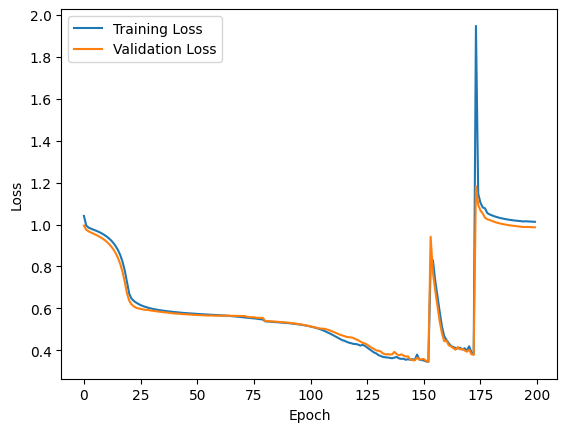

In [ ]:
### START CODE HERE ###
# Construct the model & Set the parameters.
input_size = 6  # Number of input features (1 for single sine wave value)
rnn_units = 64  # Number of units in the RNN layer
dense_units = 32  # Number of units in the Dense layer
output_size = 3  # Number of output classes
lr_decay_step = 80
lr_decay = 0.3

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Flatten())
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("softmax", None))
# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=150, learning_rate=0.003, batch_size = 32, loss_function='cce', lr_decay_step=lr_decay_step, lr_decay=lr_decay)

### END CODE HERE ###
# Plot the training and validation losses
model.plot_losses()

### 4. Predict the output and Save it
Remember to submit `y_pred.csv` to Kaggle!

In [20]:
# Do not modify this part to get the correct output format!!
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Save the predicted classes to a CSV file
y_pred_df = pd.DataFrame({
    'Id': np.arange(len(y_pred_classes)),
    'Classes': y_pred_classes
})

# Save the DataFrame to a CSV file
y_pred_df.to_csv('y_pred_advanced.csv', index=False)